In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# import crossbar
# import random
# import time

# device_params = {"Vdd": 0.2,
#                  "r_wl": 20.0,
#                  "r_bl": 20.0,
#                  "m": 10,
#                  "n": 1000,
#                  "r_on": 1e4,
#                  "r_off": 1e5,
#                  "dac_resolution": 4,
#                  "adc_resolution": 14,
#                  "bias_scheme": 1/3,
#                  "tile_rows": 10,
#                  "tile_cols": 10,
#                  "r_cmos_line": 600,
#                  "r_cmos_transistor": 20,
#                  "r_on_stddev": 1e3,
#                  "r_off_stddev": 1e4,
#                  "p_stuck_on": 0.1,
#                  "p_stuck_off": 0.1,
#                  "method": "viability",
#                  "viability": 0.3,
#                  "device": torch.device("cpu"),
#                  "device_resolution": 8,
# }

# cb = crossbar.crossbar(device_params)

# max_rows = 500
# max_cols = 10

# seed = 12
# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

# matrix = torch.rand((max_rows, max_cols)) - 0.5
# vector = torch.rand((max_cols, 1)) - 0.5
# print(matrix.shape, vector.shape)

# cb_time, t_time, error = 0.0, 0.0, 0.0

# cb.clear()
# tickett = cb.register_linear(torch.transpose(matrix,0,1))
    
# start_time = time.time()
# output = tickett.vmm(vector, v_bits=8).cpu()
# cb_time += time.time() - start_time

# start_time = time.time()
# target = matrix.matmul(vector)
# t_time += time.time() - start_time

# error += torch.norm(target - output) / torch.norm(matrix.double())

# #current_history = torch.cat(current_history, axis=1)
# print("Average crossbar vmm time:", cb_time, "s")
# print("Average torch vmm time:", t_time , "s")
# print("Average relative error:", error)

In [3]:
# import matplotlib.pyplot as plt
# def visualize_cb1(cb, m, v, tickett):
#     ls = []
#     gt = []
#     for i in range(100):
#         result = tickett.vmm(vector, v_bits=8).cpu()
#         target = m.matmul(v) 
#         ls.append(list(result))
#         gt.append(list(result-target))
#     plt.imshow(ls,  cmap=plt.cm.gray)
#     plt.colorbar()
#     plt.show()
#     plt.imshow(gt,  cmap=plt.cm.gray)
#     plt.colorbar()
#     plt.show()
    
# def visualize_cb2(cb, m, v, tickett):
#     ls = []
#     cb.clear()
#     tickett = cb.register_linear(torch.transpose(matrix,0,1))
#     for i in range(100):
#         ls.append(list(tickett.vmm(vector, v_bits=8).cpu()))
#     plt.imshow(ls,  cmap=plt.cm.gray)
#     plt.colorbar()
#     plt.show()
    
# def visualize_cb3(cbparam, m, v):
#     cb = crossbar.crossbar(cbparam)
#     ls = []
#     cb.clear()
#     tickett = cb.register_linear(torch.transpose(matrix,0,1))
#     for i in range(100):
#         ls.append(list(tickett.vmm(vector, v_bits=8).cpu()))
#     plt.imshow(ls,  cmap=plt.cm.gray)
#     plt.colorbar()
#     plt.show()
#     print(np.array(ls[10])-np.array(ls[1]))

In [4]:
#visualize_cb1(cb, matrix, vector, tickett)

In [5]:
#visualize_cb2(cb, matrix, vector, tickett)

In [6]:
# visualize_cb3(device_params, matrix, vector)

In [59]:
classes = 94
skdim = 10
noise = 0.5
dim_multiplier = 100
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [60]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-1, b=1).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-1, b=1)

# def uniform_initializer2(out_dim, in_dim, cuda = True):
#     tensor = torch.empty(out_dim, in_dim)
#     if cuda:
#         return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5).cuda()
#     else: 
#         return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5)

In [61]:
#secret keys
#ascii 0-94
secret_key = uniform_initializer(skdim, classes)
print(secret_key.shape)

torch.Size([10, 94])


In [62]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

        
from sklearn.preprocessing import MinMaxScaler
class naive_crossbar():
    def __init__(self, R_on, R_off, viability, P_stuck_on, P_stuck_off, device =  torch.device("cuda:0")):
        self.Gon = 1/R_on
        self.Goff = 1/R_off
        self.viability = viability
        self.P_stuck_on = P_stuck_on
        self.P_stuck_off = P_stuck_off
        self.device = device
    
    def stuck_filter(self, shape, P):
        return ((torch.rand(shape) > (1-P)) * 1.0).to(self.device)
        
    def apply_filter(self, W, f, weight):
        shape = W.shape
        inv = torch.ones(shape).to(self.device) - f
        return W * inv + weight * f        
        
    def convert(self, W, viability = None):
        if viability is None:
            viability = self.viability
        shape = W.shape
        #get stuck_on filter
        stuck_on_filter = self.stuck_filter(shape, self.P_stuck_on)
        #get stuck_off filter
        stuck_off_filter = self.stuck_filter(shape, self.P_stuck_off)
        
        #scaler transform
        scaler = MinMaxScaler(feature_range=(self.Goff, self.Gon))
        W = scaler.fit_transform(W.reshape(-1, 1).cpu()).reshape(shape)
        W = torch.tensor(W, dtype = torch.float, device = self.device)
        
        #add Viability
        W = apply_gaussian_noise(W, viability*(self.Gon-self.Goff))
        
        #add filters
        W = self.apply_filter(W,stuck_on_filter, self.Gon)
        W = self.apply_filter(W,stuck_off_filter, self.Goff)
        
        #clip
        W = torch.clip(W, min=self.Goff, max=self.Gon)
        W = scaler.inverse_transform(W.cpu())
        return torch.tensor(W, dtype = torch.float, device = self.device)

class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        self.cb = naive_crossbar(10e3, 10e5, 0.2, 0.05, 0.05)
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        #return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
        return (torch.matmul(self.cb.convert(self.W, sd), X) > self.epsilon).float()
    
    def apply_wnoise_realistic(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        encoded = torch.zeros((self.out_dim, X.shape[1])).to(self.device)
        for i in range(X.shape[1]):
            #encoded[:,i] = (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X[:,i].view(-1,1)) > self.epsilon).float().view(-1)
            encoded[:,i] = (torch.matmul(self.cb.convert(self.W, sd), X[:,i].view(-1,1)) > self.epsilon).float().view(-1)
        return encoded
    
# cb = naive_crossbar(10e3, 10e5, 0.2, 0.05, 0.05)
# w = torch.rand((8,8))*10
# print(w)
# print(cb.stuck_filter(w.shape, 0.05))
# print(cb.convert(w))

In [63]:
#One hot net    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon):
        super(One_hot_net, self).__init__()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        self.tail = nn.Linear(feature_len, n_class)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, X):
        X = self.f_encoder.apply_wnoise(X, noise)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        #print(X.shape)
        X = self.output(X)
        #print(X.shape)
        return X
    
    def decrypt(self, X):
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        #print(X.shape)
        X = self.output(X)
        #print(X.shape)
        return X

In [64]:
parameters = {
    'in_dim': skdim,
    'n_class': classes,
    'f_encoder': simple_encoder_wthreshold(skdim*dim_multiplier, skdim, 0),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': dim_multiplier,
    'epsilon': 0,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}

In [65]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon']).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.5, momentum=0.5)


In [66]:
#create training and testing set
def make_data(size, classes = classes):
    data = torch.rand(size) * classes
    return data.long()#, F.one_hot(data.long(), num_classes=classes)

n_epochs = 10
n_batch = 2000
batch_size_train = 50
batch_size_test = 50

train_loader = []
test_loader = []
for i in range(n_batch):
    #train
    indices = make_data(batch_size_train)
    train_loader.append((secret_key[:, indices], indices))
    
    #test
    indices = make_data(batch_size_train)
    test_loader.append((secret_key[:, indices], indices))

#train_loader = [secret_key[:, make_data(batch_size_train)] for i in range(n_batch)]
#test_loader = [secret_key[:, make_data(batch_size_test)] for i in range(n_batch)]

print(train_loader[0][0].shape, train_loader[0][1].shape, train_loader[0][1])

torch.Size([10, 50]) torch.Size([50]) tensor([76, 69, 64, 30, 63, 15, 89, 60, 34, 88, 75, 74, 86,  3, 56, 37, 16, 78,
        44, 13, 24, 13, 22, 60, 70, 44, 89, 91, 64, 54, 51,  5, 22, 73, 32, 57,
        12, 36, 76, 22,  5, 42, 52, 82, 68, 58, 71,  0, 57,  8])


In [67]:
train_losses = []
test_losses = []

In [68]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    train_loss = 0
    for batch_idx, data_set in enumerate(train_loader):
        data = data_set[0].to(device)
        labels = data_set[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape, output)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(float(train_loss))
    print('Epoch: {}, Train set: Avg. loss: {:.6f}'.format(epoch,
        train_loss))
    return model, optimizer
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data_set in test_loader:
            data = data_set[0].to(device)
            labels = data_set[1].to(device)
            output = model(data)
            test_loss += F.nll_loss(output, labels).item()
    test_loss /= len(test_loader)
    test_losses.append(float(test_loss))
    #print(output[:,0]-data[:,0])
    print('Test set: Avg. loss: {:.6f}'.format(
        test_loss))
    return test_loss

In [69]:
model_name = "crypto_net1"
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)

Epoch: 1, Train set: Avg. loss: 0.789371
Test set: Avg. loss: 0.037510
Epoch: 2, Train set: Avg. loss: 0.034836
Test set: Avg. loss: 0.016711
Epoch: 3, Train set: Avg. loss: 0.023682
Test set: Avg. loss: 0.018927
Epoch: 4, Train set: Avg. loss: 0.023303
Test set: Avg. loss: 0.012885
Epoch: 5, Train set: Avg. loss: 0.016501
Test set: Avg. loss: 0.017283
Epoch: 6, Train set: Avg. loss: 0.016401
Test set: Avg. loss: 0.010884
Epoch: 7, Train set: Avg. loss: 0.017152
Test set: Avg. loss: 0.017885
Epoch: 8, Train set: Avg. loss: 0.012472
Test set: Avg. loss: 0.010266
Epoch: 9, Train set: Avg. loss: 0.013907
Test set: Avg. loss: 0.031264
Epoch: 10, Train set: Avg. loss: 0.012806
Test set: Avg. loss: 0.008328


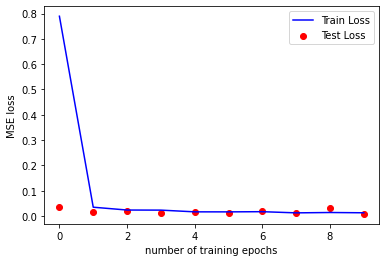

In [70]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.scatter(range(len(test_losses)), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training epochs')
plt.ylabel('MSE loss')
plt.show()

In [71]:
#Testing Encoded sentence
#message = "It is time to test the model on real-world data"#. We must choose a sentence and an image. We choose the following sentence from Wikipedia: Anthony Edward \"Tony\" Stark is a character portrayed by Robert Downey Jr. in the MCU film franchise and for the image, we use the same Tony Stark’s image from the beginning of the article. The following code is used to embedding and extracting the message:"
message = "abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [72]:
def encrypt(message, model, secret_key, n = noise):
    message_index = [(ord(c)-32) for c in message]
    #print(message_index)
    #print(secret_key)
    #sk = secret_key.cpu()
    #print(sk.shape, sk.device)
    secret_message = secret_key[:, message_index]#.to(device)
    #print(secret_message[:,0])
    return model.f_encoder.apply_wnoise_realistic(secret_message, n)

In [73]:
encrypted_message = encrypt(message, model1, secret_key, n = 0.4)

In [74]:
print(encrypted_message, encrypted_message.shape, torch.sum(encrypted_message[:,-1]-encrypted_message[:,-2]))
#plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]], device='cuda:0') torch.Size([1000, 53]) tensor(-37., device='cuda:0')


In [75]:
def determine_letter(one_hots):
    ind = torch.argmax(one_hots, dim=1)
    m = ""
    for i in ind:
        m += chr(int(i)+32)
    return m

def decrypt(encrypted_message, model, secret_key):
    raw_m = model.decrypt(encrypted_message)
    m = determine_letter(raw_m)
    return m

In [76]:
decrypted_m = decrypt(encrypted_message, model1, secret_key)
print(decrypted_m)
def decryption_accuracy(message, decrypted_message):
    count = 0
    for i in range(len(message)):
        if message[i] == decrypted_message[i]:
            count+=1
    return count/len(message) * 100
print("decryption accuracy is {}%".format(round(decryption_accuracy(message, decrypted_m), 2)))

abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
decryption accuracy is 100.0%


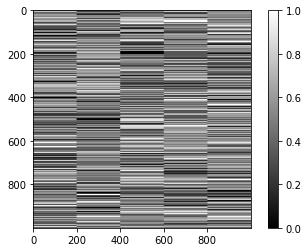

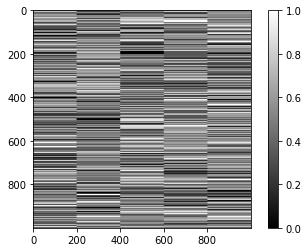

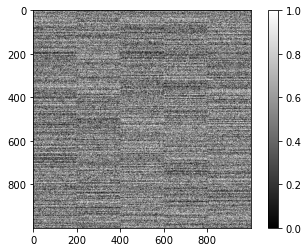

In [87]:
#Visualize variance caused by noise
def visualize(message, model, secret_key, n = noise, fname=None):
    encrypted_message = encrypt(message, model, secret_key, n = n)
    #print(encrypted_message)
    #print(torch.sum(encrypted_message[:,1]-encrypted_message[:,0]))
    plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)
    plt.colorbar()
    if fname is not None:
        plt.savefig(fname, dpi=1000)
    plt.show()

visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 0)
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 0, fname='figures/paper/decrypted_textdot0.png')
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = noise)

In [78]:
#message_index = [(ord(c)-32) for c in message]
#print(message_index)
#secret_message = secret_key[:, message_index]#.to(device)
#output = model1(secret_message)
#print(output[:,0]-secret_message[:,0])